In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp #passses tensor of the 4 operators to circuits
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager #set of optimizations param for the circuits


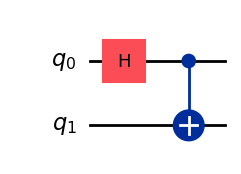

In [2]:
qc = QuantumCircuit(2)
qc.h(0)  #adding Hadamard gate to first qubit
qc.cx(0, 1)  #adding CNOT gate to second qubit controlled by first qubit


qc.draw(output='mpl')

In [3]:
observables_labels = ['IZ','IX','ZI','XI','ZZ','XX'] #each label repr tensor product of pauli operators (I-identity,X-cNOT,Z-Phase flip)
observables = [SparsePauliOp(label) for label in observables_labels] #for instance tensor product of (IZ)--identity of first qubit and  Z operator for second qubit to be flipped
#this line creates list of SparsePauliOp objects , each representing one of the operators observables in sparse matrix form


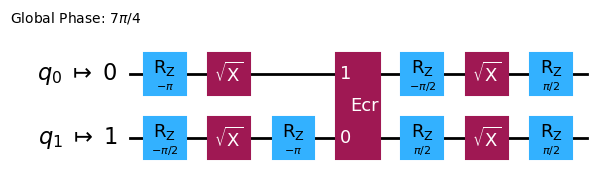

In [4]:
#optimization of the circuits and the operators

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum', token='cf70125004fa9422f6337afe3160ae67154dcf1b61ebec388ade05481b57df825d5dd53eab50b76f1f9fb0625f4e077ebfd6c544cb8c893d6a8294f7359954d1') #chanel='ibm_quantum' ,tokens='your token here from quantum ibm platform'
backend = service.least_busy(simulator=False, operational=True) #choose backend which is least busy and its areal q.device for running executing our circuits

am = generate_preset_pass_manager(backend=backend,optimization_level=1) 
isa_circuit = am.run(qc) # pass manager applies series of optimizations and transforms passes to the circuit, executing it to right target
isa_circuit.draw('mpl', idle_wires=False) #visualizes optimized circuit , ensures that unused wires are not displayed  in the visualization

In [5]:
#Executing using the quantum primitives
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimate = Estimator(backend=backend) #estimates expected values of the operators
estimate.options.resilience_level = 1
estimate.options.default_shots = 500


mapped_observables = [ observable.apply_layout(isa_circuit.layout) for observable in observables ]

job = estimate.run([(isa_circuit, mapped_observables)])

job_result = job.result()

first_result = job.result()[0]


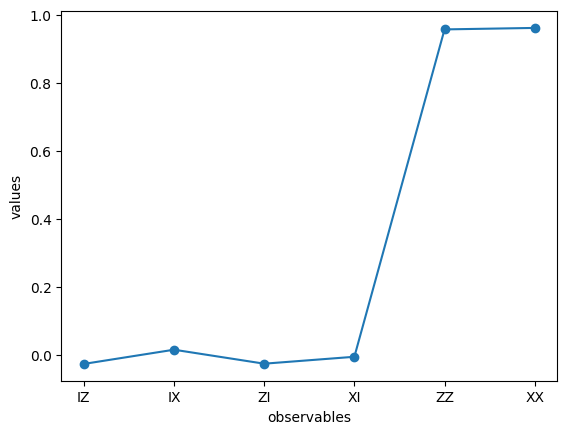

In [6]:
# Results Analysis

from matplotlib import pyplot as plt 

values  = first_result.data.evs 

errors = first_result.data.stds 

plt.plot(observables_labels, values, '-o')
plt.xlabel('observables')

plt.ylabel('values')

plt.show()
